# Taller 1: Predicción de Demanda de Bicicletas
## MINE 4206 - Aprendizaje de Máquina (AML) - 2026-10

---

**Contexto del problema:** Los sistemas de alquiler de bicicletas en entornos urbanos ofrecen una solución práctica para el transporte diario y representan una estrategia clave para mitigar el cambio climático. Uno de los retos fundamentales es anticipar y gestionar la demanda de bicicletas de manera eficiente.

**Objetivo:** Construir un modelo predictivo para estimar la demanda de bicicletas, determinando los factores que más inciden en dicha demanda.

## 0. Importación de Librerías

In [2]:
#Instalación de librerias 
!pip install seaborn scikit-learn

# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LinearRegression, Lasso

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.8 MB/s eta 0:00:00
Librerías importadas correctamente.


---
## 1. Exploración y Perfilamiento de los Datos

En esta sección realizaremos un análisis exploratorio exhaustivo para comprender la estructura, calidad y características de los datos.

### 1.1 Carga de datos

In [3]:
# Cargar el dataset
df = pd.read_csv('/Users/javiermondragon/Documents/Uniandes/Machine Learning/Taller 1/Datos_Bicicletas.csv', encoding='cp1252', sep=';')

print(f"Dimensiones del dataset: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nColumnas del dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

Dimensiones del dataset: 17379 filas x 9 columnas

Columnas del dataset:
  1. Estacion
  2. Dia_semana
  3. Condicion
  4. Temperatura
  5. Sensacion
  6. Humedad
  7. Velocidad_viento
  8. BiciRentadas
  9. Parte_dia


In [4]:
# Visualización de las primeras filas
df.head(10)

,Estacion,Dia_semana,Condicion,Temperatura,Sensacion,Humedad,Velocidad_viento,BiciRentadas,Parte_dia
0,Invierno,6,Despejado,3.28,30.014,0.81,0.000,16.0,Noche
1,Invierno,6,Despejado,2.34,19.982,0.80,0.000,40.0,Noche
2,Invierno,6,Despejado,2.34,19.982,0.80,0.000,32.0,Noche
3,Invierno,6,Despejado,3.28,30.014,0.75,0.000,13.0,Noche
4,Invierno,6,Despejado,3.28,30.014,0.75,0.000,1.0,Noche
5,Invierno,6,Niebla,3.28,10.016,0.75,60.032,1.0,Mañana
6,Invierno,6,Despejado,2.34,19.982,0.80,0.000,2.0,Mañana
7,Invierno,6,Despejado,1.40,10.016,0.86,0.000,3.0,Mañana
8,Invierno,6,Despejado,3.28,30.014,0.75,0.000,8.0,Mañana
9,Invierno,6,Despejado,7.04,7.001,0.76,0.000,14.0,Mañana


### 1.2 Información estructural del dataset

In [5]:
# Información sobre tipos de datos y valores no nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Estacion          17379 non-null  object 
 1   Dia_semana        17379 non-null  int64  
 2   Condicion         17373 non-null  object 
 3   Temperatura       17379 non-null  float64
 4   Sensacion         17379 non-null  float64
 5   Humedad           17379 non-null  float64
 6   Velocidad_viento  17374 non-null  float64
 7   BiciRentadas      17377 non-null  float64
 8   Parte_dia         17379 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.2+ MB


In [6]:
# Resumen de tipos de datos
print("\n=== Tipos de datos por columna ===")
print(df.dtypes)


=== Tipos de datos por columna ===
Estacion             object
Dia_semana            int64
Condicion            object
Temperatura         float64
Sensacion           float64
Humedad             float64
Velocidad_viento    float64
BiciRentadas        float64
Parte_dia            object
dtype: object


### 1.3 Análisis de valores faltantes

In [7]:
# Análisis detallado de valores nulos
nulos = pd.DataFrame({
    'Valores Nulos': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df) * 100).round(2)
})
nulos = nulos[nulos['Valores Nulos'] > 0]

print("=== Análisis de Valores Faltantes ===")
if len(nulos) > 0:
    print(nulos)
    print(f"\nTotal de registros con al menos un valor nulo: {df.isnull().any(axis=1).sum()}")
else:
    print("No se encontraron valores faltantes.")

=== Análisis de Valores Faltantes ===
                  Valores Nulos  Porcentaje (%)
Condicion                     6            0.03
Velocidad_viento              5            0.03
BiciRentadas                  2            0.01

Total de registros con al menos un valor nulo: 12


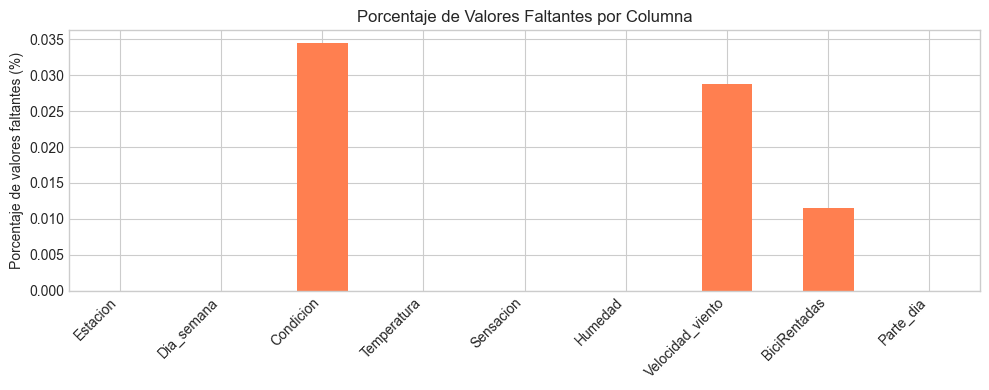

In [8]:
# Visualización de valores faltantes
fig, ax = plt.subplots(figsize=(10, 4))
missing_pct = (df.isnull().sum() / len(df) * 100)
missing_pct.plot(kind='bar', ax=ax, color='coral')
ax.set_ylabel('Porcentaje de valores faltantes (%)')
ax.set_title('Porcentaje de Valores Faltantes por Columna')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observaciones sobre valores faltantes:**
- `Condicion`: 6 valores faltantes (0.03%)
- `Velocidad_viento`: 5 valores faltantes (0.03%)
- `BiciRentadas`: 2 valores faltantes (0.01%)

El porcentaje de valores faltantes es muy bajo (<0.04%), lo que indica buena calidad de datos en términos de completitud.

### 1.4 Estadísticas descriptivas de variables numéricas

In [17]:
# Estadísticas descriptivas para variables numéricas
print("=== Estadísticas Descriptivas - Variables Numéricas ===")
df.describe().T

=== Estadísticas Descriptivas - Variables Numéricas ===


,count,mean,std,min,25%,50%,75%,max
Dia_semana,17379.0,3.003683,2.005771,0.000,1.000,3.000,5.000,6.000
Temperatura,17379.0,15.358397,9.050138,-7.060,7.980,15.500,23.020,39.000
Sensacion,17379.0,121.850463,116.144022,-149.968,17.000,110.006,229.994,489.968
Humedad,17379.0,0.627229,0.192930,0.000,0.480,0.630,0.780,1.000
Velocidad_viento,17374.0,116.126506,88.413135,0.000,60.032,110.014,169.979,569.969
BiciRentadas,17377.0,189.478966,181.391890,1.000,40.000,142.000,281.000,977.000


**Observaciones de variables numéricas:**

- `Dia_semana`: Rango de 0 a 6, representa los días de la semana (0=Lunes, 6=Domingo)
- `Temperatura`: Rango de -7.06°C a 39°C, valores razonables
- `Sensacion`: Valores fuera de rango esperado (mín: -149°C, máx: 489°C). Posible error de escala o unidad en los datos. Se eliminará en la preparación.
- `Humedad`: Rango 0-1, valores normalizados correctamente
- `Velocidad_viento`: Rango de 0 a 569.97 m/s (valor máximo parece atípico)
- `BiciRentadas`: Variable objetivo, rango de 1 a 977 bicicletas

### 1.5 Análisis de variables categóricas

In [18]:
# Variables categóricas
cat_cols = ['Estacion', 'Condicion', 'Parte_dia']

print("=== Análisis de Variables Categóricas ===")
for col in cat_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())
    print(f"Valores únicos: {df[col].nunique()}")

=== Análisis de Variables Categóricas ===

--- Estacion ---
Estacion
Verano       4496
Primavera    4409
Invierno     4242
Otoño        4232
Name: count, dtype: int64
Valores únicos: 4

--- Condicion ---
Condicion
Despejado        11410
Niebla            4542
Lluvia Leve       1418
Lluvia Fuerte        3
Name: count, dtype: int64
Valores únicos: 4

--- Parte_dia ---
Parte_dia
Noche        6471
Mañana       5801
Tarde        5103
Madrugada       4
Name: count, dtype: int64
Valores únicos: 4


In [11]:
# Análisis de Dia_semana
print("=== Análisis de Dia_semana ===")
print(df['Dia_semana'].value_counts().sort_index())
print(f"\nValores únicos: {sorted(df['Dia_semana'].unique())}")

=== Análisis de Dia_semana ===
Dia_semana
0    2502
1    2479
2    2453
3    2475
4    2471
5    2487
6    2512
Name: count, dtype: int64

Valores únicos: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


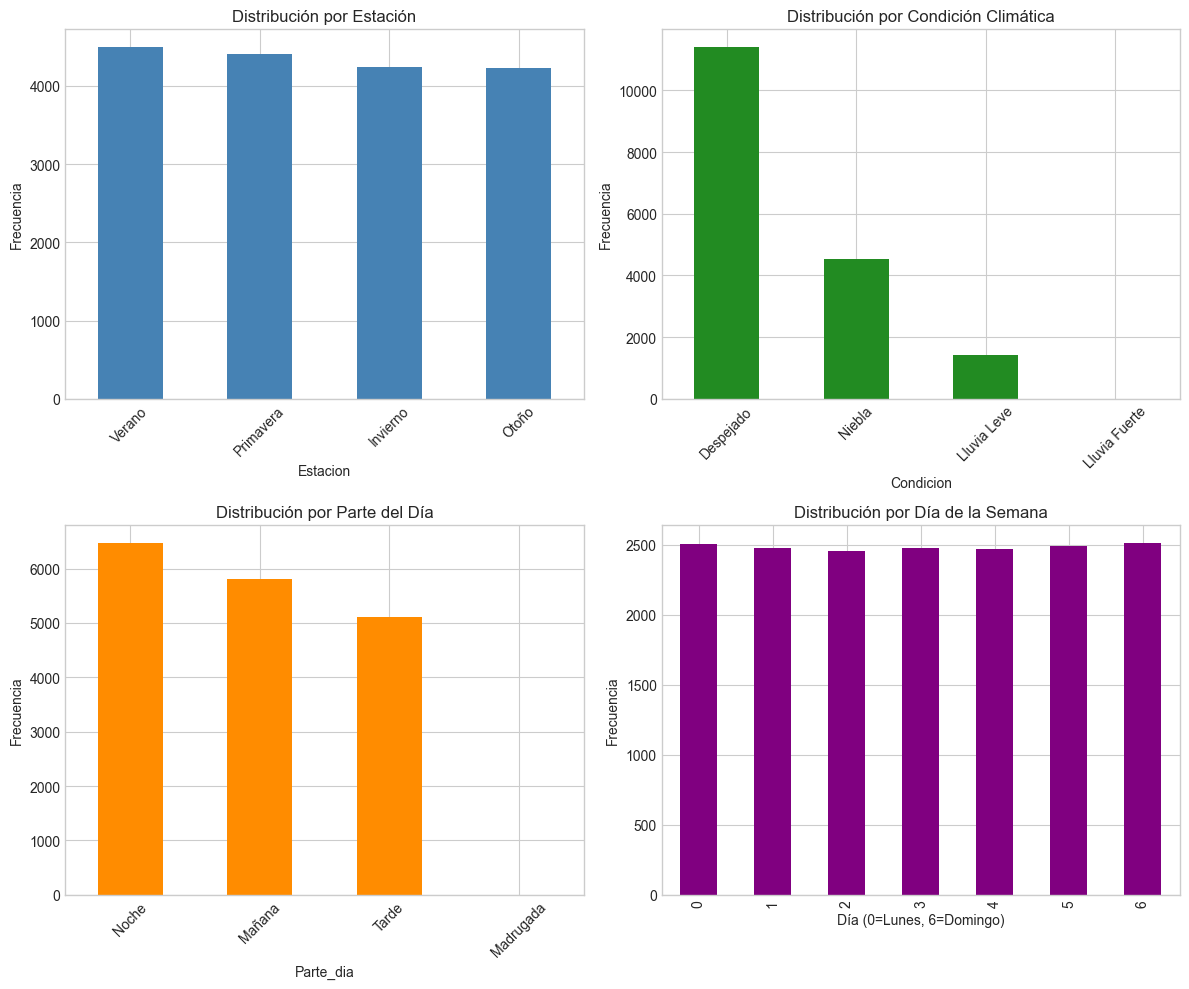

In [12]:
# Visualización de distribución de variables categóricas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Estación
df['Estacion'].value_counts().plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Distribución por Estación')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].tick_params(axis='x', rotation=45)

# Condición climática
df['Condicion'].value_counts().plot(kind='bar', ax=axes[0,1], color='forestgreen')
axes[0,1].set_title('Distribución por Condición Climática')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].tick_params(axis='x', rotation=45)

# Parte del día
df['Parte_dia'].value_counts().plot(kind='bar', ax=axes[1,0], color='darkorange')
axes[1,0].set_title('Distribución por Parte del Día')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].tick_params(axis='x', rotation=45)

# Día de la semana
df['Dia_semana'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Distribución por Día de la Semana')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_xlabel('Día (0=Lunes, 6=Domingo)')

plt.tight_layout()
plt.show()

### 1.6 Distribución de la variable objetivo

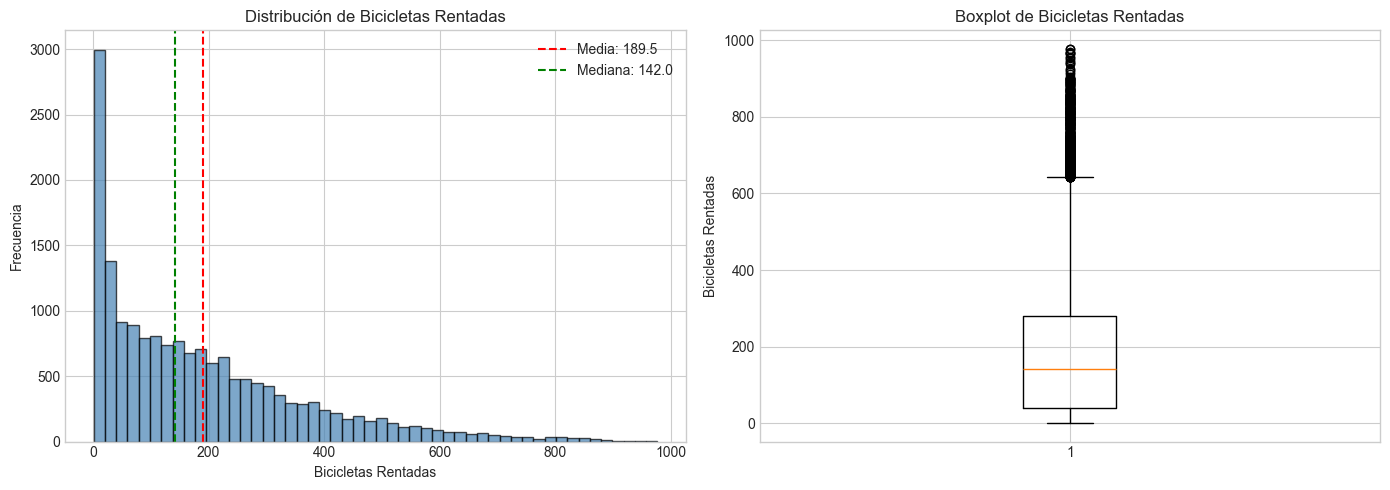

Asimetría (Skewness): 1.277
Curtosis: 1.417


In [19]:
# Distribución de BiciRentadas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df['BiciRentadas'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['BiciRentadas'].mean(), color='red', linestyle='--', label=f'Media: {df["BiciRentadas"].mean():.1f}')
axes[0].axvline(df['BiciRentadas'].median(), color='green', linestyle='--', label=f'Mediana: {df["BiciRentadas"].median():.1f}')
axes[0].set_xlabel('Bicicletas Rentadas')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Bicicletas Rentadas')
axes[0].legend()

# Boxplot
axes[1].boxplot(df['BiciRentadas'].dropna(), vert=True)
axes[1].set_ylabel('Bicicletas Rentadas')
axes[1].set_title('Boxplot de Bicicletas Rentadas')

plt.tight_layout()
plt.show()

print(f"Asimetría (Skewness): {df['BiciRentadas'].skew():.3f}")
print(f"Curtosis: {df['BiciRentadas'].kurtosis():.3f}")

**Observaciones sobre la variable objetivo:**

- La distribución presenta asimetría positiva (sesgada a la derecha)
- La media (189.5) es mayor que la mediana (142), confirmando la asimetría
- Existen valores atípicos en el extremo superior (picos de demanda superiores a 600 bicicletas)

**Interpretación práctica:**
- La mayoría del tiempo se rentan entre 40 y 280 bicicletas (rango intercuartílico)
- El 50% de las observaciones tienen menos de 142 bicicletas rentadas
- Existen momentos de alta demanda (picos) donde se superan las 600-900 bicicletas, probablemente asociados a condiciones climáticas favorables, horarios pico o eventos especiales
- Los operadores del sistema deben anticipar estos picos para garantizar disponibilidad

### 1.7 Análisis de correlaciones

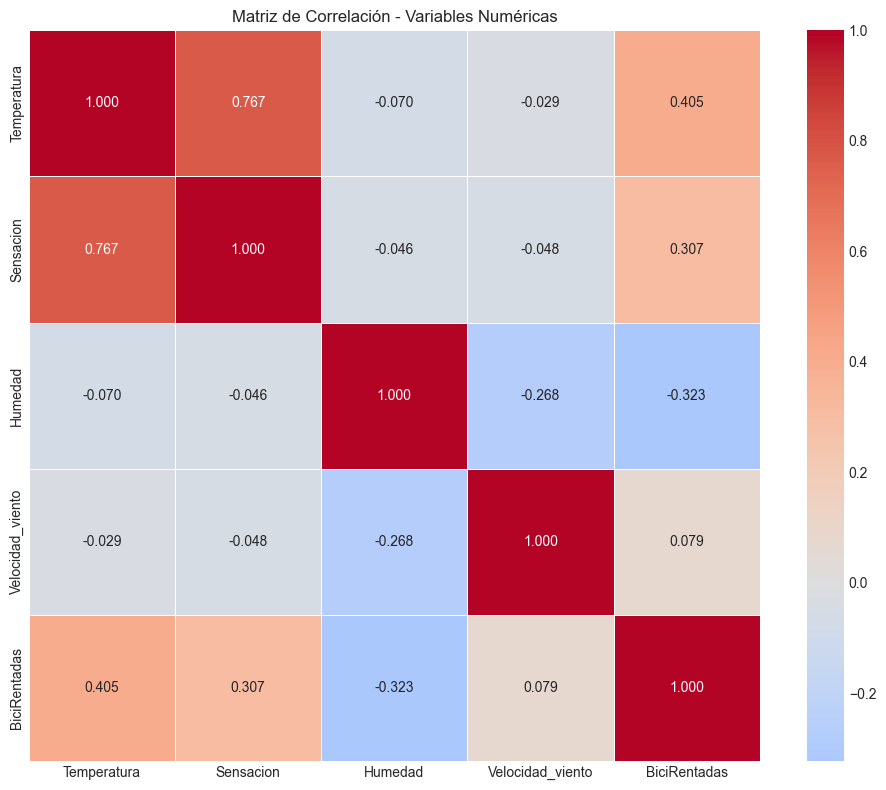

In [20]:
# Matriz de correlación para variables numéricas
num_cols = ['Temperatura', 'Sensacion', 'Humedad', 'Velocidad_viento', 'BiciRentadas']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=0.5)
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

In [15]:
# Correlación con la variable objetivo
print("=== Correlación con BiciRentadas ===")
correlaciones = df[num_cols].corr()['BiciRentadas'].drop('BiciRentadas').sort_values(key=abs, ascending=False)
print(correlaciones)

=== Correlación con BiciRentadas ===
Temperatura         0.404706
Humedad            -0.322899
Sensacion           0.307230
Velocidad_viento    0.079238
Name: BiciRentadas, dtype: float64


**Observaciones sobre correlaciones:**

- `Temperatura` tiene la mayor correlación positiva con `BiciRentadas` (0.405): a mayor temperatura, más bicicletas se rentan
- `Humedad` tiene correlación negativa con `BiciRentadas` (-0.323): a mayor humedad, menos bicicletas se rentan
- `Sensacion` también tiene correlación positiva con `BiciRentadas` (0.307)
- `Velocidad_viento` tiene correlación muy débil con `BiciRentadas` (0.079): el viento casi no influye en la demanda
- `Temperatura` y `Sensacion` están correlacionadas entre sí (0.767), lo que indica cierta redundancia entre estas variables

**Interpretación práctica:**
- Los días cálidos y secos generan mayor demanda de bicicletas
- La humedad es un factor disuasivo para los usuarios
- El viento no parece afectar significativamente la decisión de rentar

### 1.8 Análisis de relación entre variables categóricas y la variable objetivo

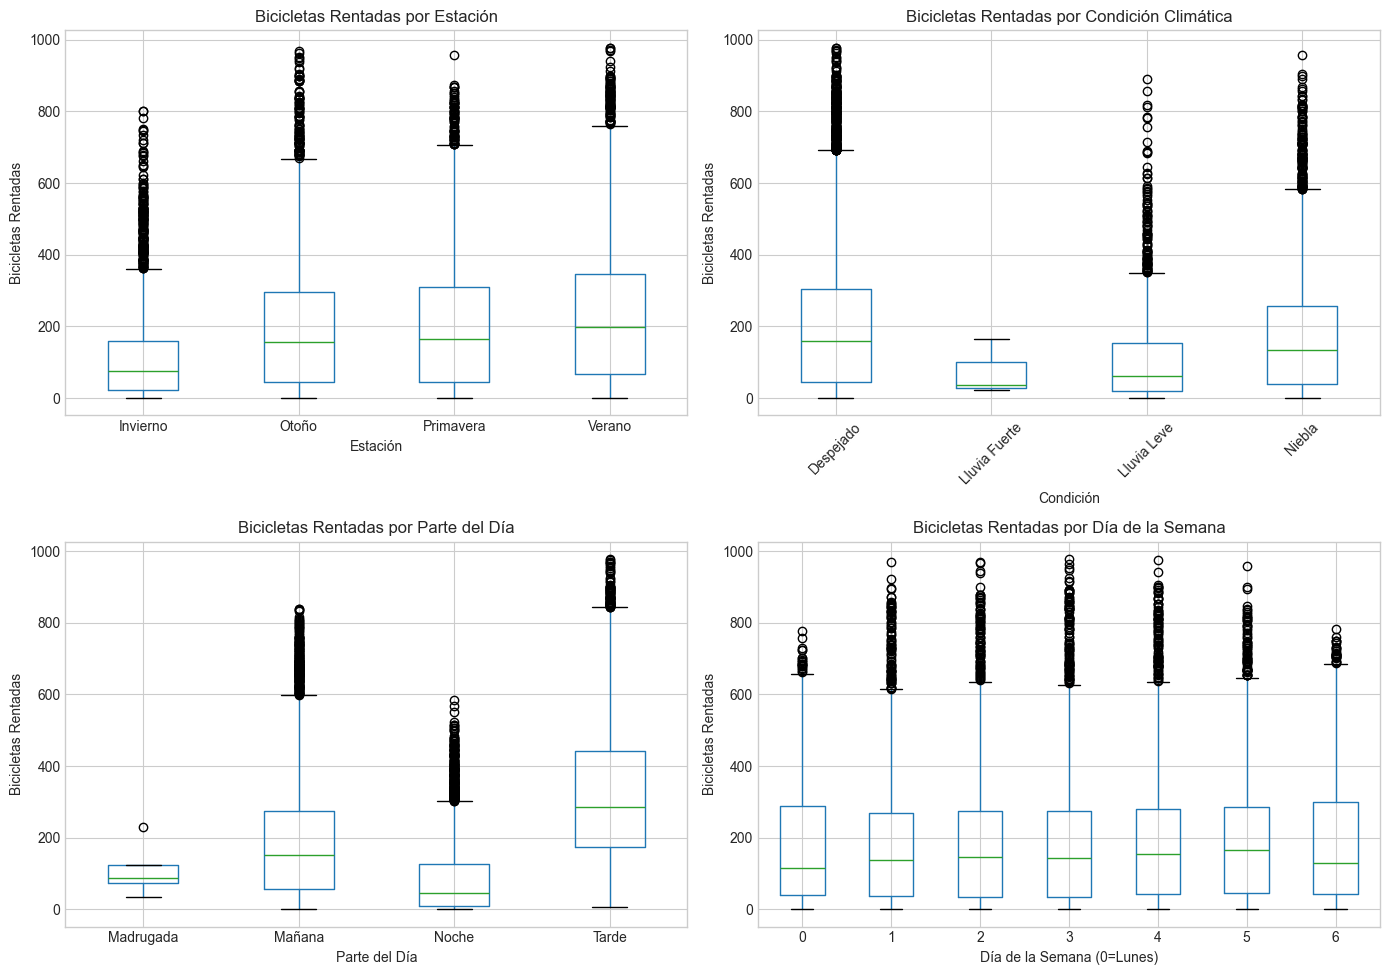

In [23]:
# Boxplots de BiciRentadas por categorías
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Por Estación
df.boxplot(column='BiciRentadas', by='Estacion', ax=axes[0,0])
axes[0,0].set_title('Bicicletas Rentadas por Estación')
axes[0,0].set_xlabel('Estación')
axes[0,0].set_ylabel('Bicicletas Rentadas')

# Por Condición
df.boxplot(column='BiciRentadas', by='Condicion', ax=axes[0,1])
axes[0,1].set_title('Bicicletas Rentadas por Condición Climática')
axes[0,1].set_xlabel('Condición')
axes[0,1].set_ylabel('Bicicletas Rentadas')
axes[0,1].tick_params(axis='x', rotation=45)

# Por Parte del día
df.boxplot(column='BiciRentadas', by='Parte_dia', ax=axes[1,0])
axes[1,0].set_title('Bicicletas Rentadas por Parte del Día')
axes[1,0].set_xlabel('Parte del Día')
axes[1,0].set_ylabel('Bicicletas Rentadas')

# Por Día de la semana
df.boxplot(column='BiciRentadas', by='Dia_semana', ax=axes[1,1])
axes[1,1].set_title('Bicicletas Rentadas por Día de la Semana')
axes[1,1].set_xlabel('Día de la Semana (0=Lunes)')
axes[1,1].set_ylabel('Bicicletas Rentadas')

plt.suptitle('')  # Eliminar título por defecto
plt.tight_layout()
plt.show()

In [24]:
# Estadísticas por categoría
print("=== Promedio de Bicicletas Rentadas por Categoría ===")
print("\n--- Por Estación ---")
print(df.groupby('Estacion')['BiciRentadas'].mean().sort_values(ascending=False))

print("\n--- Por Condición Climática ---")
print(df.groupby('Condicion')['BiciRentadas'].mean().sort_values(ascending=False))

print("\n--- Por Parte del Día ---")
print(df.groupby('Parte_dia')['BiciRentadas'].mean().sort_values(ascending=False))

=== Promedio de Bicicletas Rentadas por Categoría ===

--- Por Estación ---
Estacion
Verano       236.016237
Primavera    208.344069
Otoño        198.868856
Invierno     111.142689
Name: BiciRentadas, dtype: float64

--- Por Condición Climática ---
Condicion
Despejado        204.929179
Niebla           175.211581
Lluvia Leve      111.652327
Lluvia Fuerte     74.333333
Name: BiciRentadas, dtype: float64

--- Por Parte del Día ---
Parte_dia
Tarde        322.337645
Mañana       190.627694
Madrugada    110.250000
Noche         83.726781
Name: BiciRentadas, dtype: float64


**Observaciones sobre variables categóricas y demanda:**

**Por Estación:**
- Verano y Primavera tienen la mayor demanda, con promedios de 236 y 208 bicicletas respectivamente
- Invierno tiene la menor demanda (promedio de 111), casi la mitad que en verano
- Todas las estaciones presentan valores atípicos de alta demanda

**Por Condición Climática:**
- Días despejados tienen la mayor demanda (promedio de 205) y mayor variabilidad
- Lluvia fuerte reduce drásticamente la demanda a un promedio de 74 bicicletas, casi 3 veces menos que en días despejados
- Lluvia leve (112) y niebla (175) tienen demanda moderada

**Por Parte del Día:**
- La Tarde es el momento de mayor demanda con un promedio de 322 bicicletas, casi 4 veces más que la noche
- Madrugada (110) y Noche (84) tienen la menor demanda
- Mañana tiene demanda moderada (191) con alta variabilidad

**Por Día de la Semana:**
- La demanda es relativamente similar entre días, con medianas entre 100-150
- No hay diferencias marcadas entre días laborales y fin de semana
- Todos los días presentan picos de demanda (outliers)

**Conclusión:** La parte del día y las condiciones climáticas son los factores más determinantes para la demanda. La estación del año también influye significativamente, mientras que el día de la semana tiene poco impacto.

### 1.9 Detección de valores atípicos

In [25]:
# Análisis de outliers usando IQR
def detectar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return len(outliers), limite_inferior, limite_superior

print("=== Detección de Valores Atípicos (Método IQR) ===")
num_cols_outliers = ['Temperatura', 'Sensacion', 'Humedad', 'Velocidad_viento', 'BiciRentadas']
for col in num_cols_outliers:
    n_outliers, lim_inf, lim_sup = detectar_outliers_iqr(df, col)
    pct = (n_outliers / len(df) * 100)
    print(f"{col}: {n_outliers} outliers ({pct:.2f}%) | Límites: [{lim_inf:.2f}, {lim_sup:.2f}]")

=== Detección de Valores Atípicos (Método IQR) ===
Temperatura: 0 outliers (0.00%) | Límites: [-14.58, 45.58]
Sensacion: 0 outliers (0.00%) | Límites: [-302.49, 549.49]
Humedad: 22 outliers (0.13%) | Límites: [0.03, 1.23]
Velocidad_viento: 227 outliers (1.31%) | Límites: [-104.89, 334.90]
BiciRentadas: 505 outliers (2.91%) | Límites: [-321.50, 642.50]


### 1.10 Resumen del perfilamiento

**Hallazgos principales:**

1. **Calidad de datos:**
   - Valores faltantes: `Condicion` (6), `Velocidad_viento` (5), `BiciRentadas` (2)
   - Tipos de datos correctos en general
   - `Dia_semana` tiene valores 0-6 en lugar de 1-7 según el diccionario
   - `Sensacion` presenta valores fuera de rango (-149 a 489), posible error de escala

2. **Variables numéricas:**
   - Correlación moderada entre `Temperatura` y `Sensacion` (0.767)
   - `Velocidad_viento` tiene 227 outliers (1.31%), con valor máximo de 570 m/s que parece irreal
   - `BiciRentadas` tiene 505 outliers (2.91%), correspondientes a picos de alta demanda

3. **Variable objetivo:**
   - Distribución sesgada a la derecha
   - Rango de 1 a 977 bicicletas
   - La mayoría de observaciones están entre 40-280 bicicletas

4. **Variables categóricas:**
   - Distribución razonablemente balanceada
   - `Parte_dia` tiene 4 categorías: Mañana, Tarde, Noche, Madrugada

5. **Patrones identificados:**
   - Mayor demanda en Verano y Primavera
   - Menor demanda con lluvia fuerte
   - Mayor demanda en la Tarde (promedio 322 bicicletas)

---
## 2. Limpieza y Preparación de los Datos

Con base en el análisis exploratorio, realizaremos las siguientes acciones de limpieza y preparación.

### 2.1 Copia del dataset original

In [26]:
# Crear copia para trabajar
df_clean = df.copy()
print(f"Registros iniciales: {len(df_clean)}")

Registros iniciales: 17379


### 2.2 Tratamiento de valores faltantes

**Decisión:** Dado que el porcentaje de valores faltantes es muy bajo (<0.04%), eliminaremos las filas con valores nulos. Esta estrategia es apropiada porque:
- La pérdida de información es mínima
- Evitamos introducir sesgos por imputación
- Mantenemos la integridad de los datos

In [27]:
# Eliminar filas con valores nulos
registros_antes = len(df_clean)
df_clean = df_clean.dropna()
registros_despues = len(df_clean)

print(f"Registros antes: {registros_antes}")
print(f"Registros después: {registros_despues}")
print(f"Registros eliminados: {registros_antes - registros_despues} ({(registros_antes - registros_despues)/registros_antes*100:.3f}%)")
print(f"\nVerificación de valores nulos:")
print(df_clean.isnull().sum())

Registros antes: 17379
Registros después: 17367
Registros eliminados: 12 (0.069%)

Verificación de valores nulos:
Estacion            0
Dia_semana          0
Condicion           0
Temperatura         0
Sensacion           0
Humedad             0
Velocidad_viento    0
BiciRentadas        0
Parte_dia           0
dtype: int64


### 2.3 Tratamiento de la columna Sensacion

**Decisión:** Eliminaremos la columna `Sensacion` por dos razones:

1. **Problemas de calidad:** Los valores están fuera de rango razonable para temperatura (mínimo -149°C, máximo 489°C), lo que indica un posible error de escala o unidad en los datos originales.

2. **Redundancia:** Existe correlación moderada con `Temperatura` (0.767), por lo que aporta información similar.

Mantener esta variable con datos de calidad dudosa podría afectar negativamente el rendimiento del modelo.

In [28]:
# Eliminar columna Sensacion por multicolinealidad
df_clean = df_clean.drop(columns=['Sensacion'])
print("Columna 'Sensacion' eliminada por multicolinealidad con 'Temperatura'.")
print(f"\nColumnas restantes: {list(df_clean.columns)}")

Columna 'Sensacion' eliminada por multicolinealidad con 'Temperatura'.

Columnas restantes: ['Estacion', 'Dia_semana', 'Condicion', 'Temperatura', 'Humedad', 'Velocidad_viento', 'BiciRentadas', 'Parte_dia']


### 2.4 Definición de variables

**Justificación de la selección de variables:**
- **Variables numéricas:** Temperatura, Humedad, Velocidad_viento (factores meteorológicos que influyen en la decisión de usar bicicleta)
- **Variables categóricas:** Estacion, Dia_semana, Condicion, Parte_dia (factores temporales y climáticos)
- **Variable objetivo:** BiciRentadas

In [29]:
# Definir variables predictoras y objetivo
target = 'BiciRentadas'
cat_features = ['Estacion', 'Condicion', 'Parte_dia']
num_features = ['Temperatura', 'Humedad', 'Velocidad_viento']

# Dia_semana lo trataremos como categórico (es ordinal pero tiene pocos valores)
df_clean['Dia_semana'] = df_clean['Dia_semana'].astype(str)
cat_features.append('Dia_semana')

print(f"Variable objetivo: {target}")
print(f"Variables categóricas: {cat_features}")
print(f"Variables numéricas: {num_features}")

Variable objetivo: BiciRentadas
Variables categóricas: ['Estacion', 'Condicion', 'Parte_dia', 'Dia_semana']
Variables numéricas: ['Temperatura', 'Humedad', 'Velocidad_viento']


### 2.5 División de datos en entrenamiento y prueba

In [30]:
# Separar features y target
X = df_clean[num_features + cat_features]
y = df_clean[target]

# División train-test con random_state=77 según indicaciones
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=77
)

print(f"Tamaño conjunto de entrenamiento: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Tamaño conjunto de prueba: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

Tamaño conjunto de entrenamiento: 13893 (80.0%)
Tamaño conjunto de prueba: 3474 (20.0%)


### 2.6 Construcción del Pipeline de preprocesamiento

**Estrategia de preprocesamiento:**
- **Variables numéricas:** Escalado estándar (StandardScaler) para normalizar las escalas
- **Variables categóricas:** Codificación One-Hot para convertir a variables dummy

In [31]:
# Definir transformadores para cada tipo de variable
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combinar transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='passthrough'
)

print("Pipeline de preprocesamiento configurado correctamente.")

Pipeline de preprocesamiento configurado correctamente.


In [32]:
# Aplicar preprocesamiento para verificar
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Obtener nombres de las features transformadas
feature_names_num = num_features
feature_names_cat = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
all_feature_names = list(feature_names_num) + list(feature_names_cat)

print(f"Dimensión de X_train después del preprocesamiento: {X_train_prep.shape}")
print(f"Dimensión de X_test después del preprocesamiento: {X_test_prep.shape}")
print(f"\nNúmero total de features: {len(all_feature_names)}")
print(f"\nFeatures generadas:")
for i, name in enumerate(all_feature_names, 1):
    print(f"  {i}. {name}")

Dimensión de X_train después del preprocesamiento: (13893, 18)
Dimensión de X_test después del preprocesamiento: (3474, 18)

Número total de features: 18

Features generadas:
  1. Temperatura
  2. Humedad
  3. Velocidad_viento
  4. Estacion_Otoño
  5. Estacion_Primavera
  6. Estacion_Verano
  7. Condicion_Lluvia Fuerte
  8. Condicion_Lluvia Leve
  9. Condicion_Niebla
  10. Parte_dia_Mañana
  11. Parte_dia_Noche
  12. Parte_dia_Tarde
  13. Dia_semana_1
  14. Dia_semana_2
  15. Dia_semana_3
  16. Dia_semana_4
  17. Dia_semana_5
  18. Dia_semana_6


---
## 3. Construcción del Modelo de Regresión Polinomial

Se construirá un modelo de regresión polinomial evaluando grados 2 y 3, seleccionando el mejor mediante validación cruzada y la métrica RMSE.

### 3.1 Definición de la búsqueda de hiperparámetros

In [41]:
# Para el modelo polinomial, trabajaremos solo con variables numéricas transformadas
# y las categóricas ya codificadas, evitando la explosión de dimensionalidad

from sklearn.preprocessing import PolynomialFeatures

# Primero, transformamos los datos con el preprocessor ya definido
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Dimensiones después del preprocesamiento: {X_train_transformed.shape}")

Dimensiones después del preprocesamiento: (13893, 18)


In [43]:
from sklearn.linear_model import Ridge

# Definir los grados de polinomio a evaluar
degrees = [2, 3]
poly_results = []

print("=== Selección del Grado de Polinomio mediante Validación Cruzada ===")
print(f"Grados a evaluar: {degrees}")
print(f"Métrica de selección: RMSE (menor es mejor)\n")

for degree in degrees:
    poly_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=1.0))  # Ridge en lugar de LinearRegression
    ])
    
    cv_scores = cross_val_score(
        poly_pipeline, X_train_transformed, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    
    rmse_scores = np.sqrt(-cv_scores)
    rmse_mean = rmse_scores.mean()
    rmse_std = rmse_scores.std()
    
    poly_results.append({
        'Grado': degree,
        'RMSE_mean': rmse_mean,
        'RMSE_std': rmse_std
    })
    
    print(f"Grado {degree}: RMSE = {rmse_mean:.4f} (+/- {rmse_std:.4f})")

=== Selección del Grado de Polinomio mediante Validación Cruzada ===
Grados a evaluar: [2, 3]
Métrica de selección: RMSE (menor es mejor)

Grado 2: RMSE = 131.5993 (+/- 1.9943)
Grado 3: RMSE = 128.7382 (+/- 2.1082)


In [44]:
# Verificar que los datos estén correctos
print("=== Verificación de datos ===")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nValores de y_train:")
print(f"  Min: {y_train.min()}")
print(f"  Max: {y_train.max()}")
print(f"  Mean: {y_train.mean():.2f}")
print(f"\nPrimeras filas de X_train:")
print(X_train.head())
print(f"\nTipos de datos:")
print(X_train.dtypes)

=== Verificación de datos ===
X_train shape: (13893, 7)
y_train shape: (13893,)

Valores de y_train:
  Min: 1.0
  Max: 977.0
  Mean: 188.75

Primeras filas de X_train:
       Temperatura  Humedad  Velocidad_viento  Estacion  Condicion Parte_dia  \
9398         12.68     0.54            70.015  Invierno  Despejado    Mañana   
1046          2.34     0.55           110.014  Invierno     Niebla    Mañana   
5009         34.30     0.27             0.000    Verano  Despejado     Tarde   
5640         24.90     0.58           260.027    Verano  Despejado    Mañana   
14253        21.14     0.78             0.000    Verano  Despejado     Noche   

      Dia_semana  
9398           3  
1046           3  
5009           1  
5640           0  
14253          3  

Tipos de datos:
Temperatura         float64
Humedad             float64
Velocidad_viento    float64
Estacion             object
Condicion            object
Parte_dia            object
Dia_semana           object
dtype: object


In [45]:
# Crear DataFrame con resultados
df_poly_results = pd.DataFrame(poly_results)
print("\n=== Resultados de Validación Cruzada ===")
print(df_poly_results.to_string(index=False))

# Seleccionar el mejor grado
best_degree = df_poly_results.loc[df_poly_results['RMSE_mean'].idxmin(), 'Grado']
best_rmse_poly = df_poly_results.loc[df_poly_results['RMSE_mean'].idxmin(), 'RMSE_mean']

print(f"\n✓ Mejor grado de polinomio seleccionado: {best_degree}")
print(f"✓ RMSE en validación cruzada: {best_rmse_poly:.4f}")


=== Resultados de Validación Cruzada ===
 Grado  RMSE_mean  RMSE_std
     2 131.599263  1.994287
     3 128.738235  2.108174

✓ Mejor grado de polinomio seleccionado: 3
✓ RMSE en validación cruzada: 128.7382


### 3.2 Entrenamiento del modelo polinomial final

In [46]:
# Crear y entrenar el modelo final con el mejor grado
poly_final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=int(best_degree), include_bias=False)),
    ('regressor', LinearRegression())
])

poly_final_pipeline.fit(X_train, y_train)
print(f"Modelo de Regresión Polinomial (grado={int(best_degree)}) entrenado exitosamente.")

Modelo de Regresión Polinomial (grado=3) entrenado exitosamente.


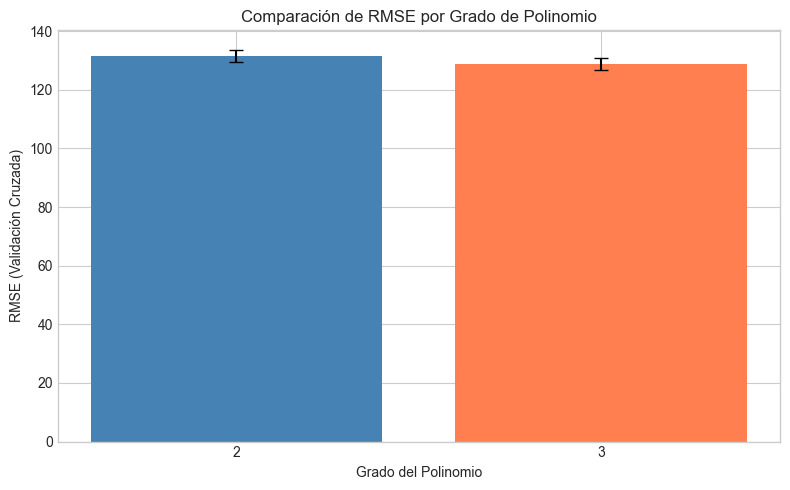

In [47]:
# Visualizar resultados de validación cruzada
plt.figure(figsize=(8, 5))
plt.bar([str(d) for d in df_poly_results['Grado']], df_poly_results['RMSE_mean'], 
        yerr=df_poly_results['RMSE_std'], capsize=5, color=['steelblue', 'coral'])
plt.xlabel('Grado del Polinomio')
plt.ylabel('RMSE (Validación Cruzada)')
plt.title('Comparación de RMSE por Grado de Polinomio')
plt.tight_layout()
plt.show()

**Análisis de selección del grado polinomial:**

Se evaluaron polinomios de grado 2 y 3 mediante validación cruzada (5 folds). El grado 3 obtuvo un RMSE ligeramente menor (128.74) que el grado 2 (131.60), una mejora de aproximadamente 2.2%.

Las barras de error muestran que la diferencia es consistente entre los folds de validación, lo que sugiere que el grado 3 generaliza mejor. Sin embargo, la mejora es modesta, indicando que las relaciones no lineales adicionales capturadas por el grado 3 aportan poco poder predictivo extra.

Se selecciona el **grado 3** por tener el menor RMSE.

---
## 4. Construcción del Modelo de Regresión Lasso

Se construirá un modelo Lasso evaluando diferentes valores de α (regularización), seleccionando el mejor mediante validación cruzada y la métrica RMSE.

### 4.1 Definición de la búsqueda de hiperparámetros

In [48]:
# Definir los valores de alpha a evaluar
alphas = [1, 2, 3, 4, 5]

# Almacenar resultados
lasso_results = []

print("=== Selección de Alpha para Regresión Lasso mediante Validación Cruzada ===")
print(f"Valores de alpha a evaluar: {alphas}")
print(f"Métrica de selección: RMSE (menor es mejor)")
print(f"\nEvaluando...")

=== Selección de Alpha para Regresión Lasso mediante Validación Cruzada ===
Valores de alpha a evaluar: [1, 2, 3, 4, 5]
Métrica de selección: RMSE (menor es mejor)

Evaluando...


In [49]:
# Evaluar cada valor de alpha
for alpha in alphas:
    # Crear pipeline con Lasso
    lasso_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=alpha, max_iter=10000))
    ])
    
    # Validación cruzada
    cv_scores = cross_val_score(
        lasso_pipeline, X_train, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    
    # Calcular RMSE promedio
    rmse_scores = np.sqrt(-cv_scores)
    rmse_mean = rmse_scores.mean()
    rmse_std = rmse_scores.std()
    
    lasso_results.append({
        'Alpha': alpha,
        'RMSE_mean': rmse_mean,
        'RMSE_std': rmse_std
    })
    
    print(f"Alpha {alpha}: RMSE = {rmse_mean:.4f} (+/- {rmse_std:.4f})")

Alpha 1: RMSE = 136.4949 (+/- 1.9097)
Alpha 2: RMSE = 136.9203 (+/- 1.9250)
Alpha 3: RMSE = 137.5810 (+/- 1.8734)
Alpha 4: RMSE = 138.0148 (+/- 1.7760)
Alpha 5: RMSE = 138.4405 (+/- 1.7009)


In [50]:
# Crear DataFrame con resultados
df_lasso_results = pd.DataFrame(lasso_results)
print("\n=== Resultados de Validación Cruzada ===")
print(df_lasso_results.to_string(index=False))

# Seleccionar el mejor alpha
best_alpha = df_lasso_results.loc[df_lasso_results['RMSE_mean'].idxmin(), 'Alpha']
best_rmse_lasso = df_lasso_results.loc[df_lasso_results['RMSE_mean'].idxmin(), 'RMSE_mean']

print(f"\n✓ Mejor valor de alpha seleccionado: {best_alpha}")
print(f"✓ RMSE en validación cruzada: {best_rmse_lasso:.4f}")


=== Resultados de Validación Cruzada ===
 Alpha  RMSE_mean  RMSE_std
     1 136.494921  1.909678
     2 136.920278  1.924979
     3 137.581041  1.873423
     4 138.014770  1.776042
     5 138.440546  1.700931

✓ Mejor valor de alpha seleccionado: 1
✓ RMSE en validación cruzada: 136.4949


### 4.2 Entrenamiento del modelo Lasso final

In [51]:
# Crear y entrenar el modelo final con el mejor alpha
lasso_final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=int(best_alpha), max_iter=10000))
])

lasso_final_pipeline.fit(X_train, y_train)
print(f"Modelo de Regresión Lasso (alpha={int(best_alpha)}) entrenado exitosamente.")

Modelo de Regresión Lasso (alpha=1) entrenado exitosamente.


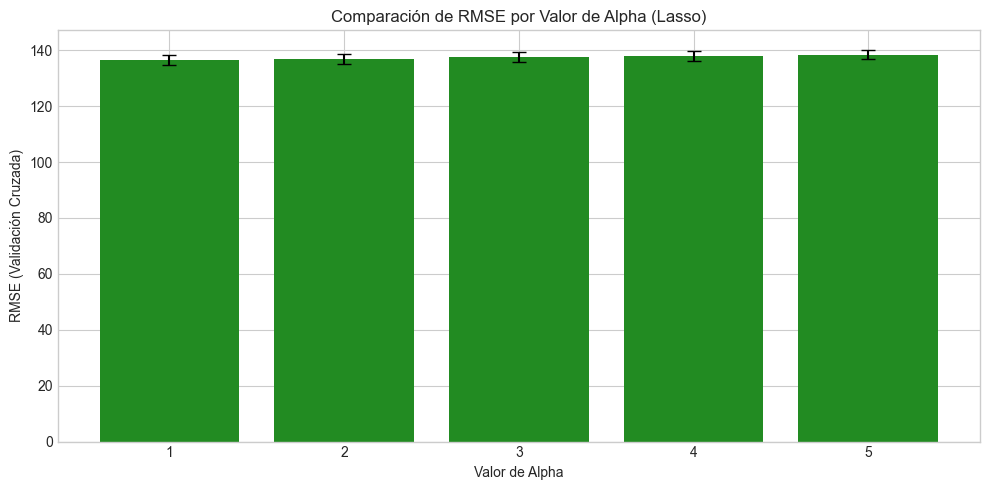

In [52]:
# Visualizar resultados de validación cruzada
plt.figure(figsize=(10, 5))
plt.bar([str(a) for a in df_lasso_results['Alpha']], df_lasso_results['RMSE_mean'], 
        yerr=df_lasso_results['RMSE_std'], capsize=5, color='forestgreen')
plt.xlabel('Valor de Alpha')
plt.ylabel('RMSE (Validación Cruzada)')
plt.title('Comparación de RMSE por Valor de Alpha (Lasso)')
plt.tight_layout()
plt.show()

**Análisis de selección del parámetro alpha (Lasso):**

Se evaluaron valores de alpha de 1 a 5 mediante validación cruzada. Los resultados muestran que a mayor alpha, mayor RMSE, lo que indica que una regularización más fuerte penaliza demasiado los coeficientes y reduce el poder predictivo.

Alpha = 1 obtuvo el mejor RMSE (136.49), aunque las diferencias entre todos los valores son pequeñas (menos de 2 unidades). Esto sugiere que el modelo es relativamente estable ante cambios en la regularización.

Se selecciona **alpha = 1** por tener el menor RMSE.

---
## 5. Tabla Comparativa de Rendimiento

Evaluación de los dos mejores modelos sobre el conjunto de prueba.

In [54]:
# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

In [55]:
# Entrenar modelo polinomial final con los datos transformados
poly_final = Pipeline([
    ('poly', PolynomialFeatures(degree=int(best_degree), include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))
])
poly_final.fit(X_train_transformed, y_train)

# Entrenar modelo Lasso final
lasso_final = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=int(best_alpha), max_iter=10000))
])
lasso_final.fit(X_train_transformed, y_train)

# Predicciones sobre el conjunto de prueba
y_pred_poly = poly_final.predict(X_test_transformed)
y_pred_lasso = lasso_final.predict(X_test_transformed)

# Calcular métricas
metricas_poly = calcular_metricas(y_test, y_pred_poly)
metricas_lasso = calcular_metricas(y_test, y_pred_lasso)

# Crear tabla comparativa
tabla_comparativa = pd.DataFrame({
    'Modelo': [f'Regresión Polinomial (grado={int(best_degree)})', 
               f'Regresión Lasso (alpha={int(best_alpha)})'],
    'R²': [metricas_poly['R2'], metricas_lasso['R2']],
    'RMSE': [metricas_poly['RMSE'], metricas_lasso['RMSE']],
    'MAE': [metricas_poly['MAE'], metricas_lasso['MAE']]
})

print("="*70)
print("         TABLA COMPARATIVA DE RENDIMIENTO SOBRE CONJUNTO TEST")
print("="*70)
print(tabla_comparativa.to_string(index=False))
print("="*70)

         TABLA COMPARATIVA DE RENDIMIENTO SOBRE CONJUNTO TEST
                        Modelo       R²       RMSE        MAE
Regresión Polinomial (grado=3) 0.506587 128.599953  93.462096
     Regresión Lasso (alpha=1) 0.423026 139.063654 102.569578


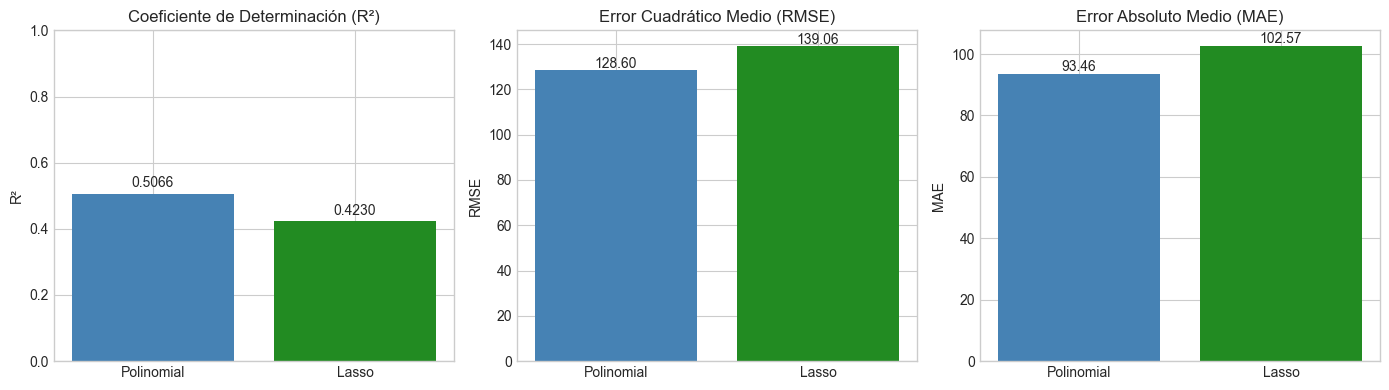

In [56]:
# Visualización de las métricas
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

modelos = ['Polinomial', 'Lasso']
colores = ['steelblue', 'forestgreen']

# R²
axes[0].bar(modelos, [metricas_poly['R2'], metricas_lasso['R2']], color=colores)
axes[0].set_ylabel('R²')
axes[0].set_title('Coeficiente de Determinación (R²)')
axes[0].set_ylim(0, 1)
for i, v in enumerate([metricas_poly['R2'], metricas_lasso['R2']]):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center')

# RMSE
axes[1].bar(modelos, [metricas_poly['RMSE'], metricas_lasso['RMSE']], color=colores)
axes[1].set_ylabel('RMSE')
axes[1].set_title('Error Cuadrático Medio (RMSE)')
for i, v in enumerate([metricas_poly['RMSE'], metricas_lasso['RMSE']]):
    axes[1].text(i, v + 1, f'{v:.2f}', ha='center')

# MAE
axes[2].bar(modelos, [metricas_poly['MAE'], metricas_lasso['MAE']], color=colores)
axes[2].set_ylabel('MAE')
axes[2].set_title('Error Absoluto Medio (MAE)')
for i, v in enumerate([metricas_poly['MAE'], metricas_lasso['MAE']]):
    axes[2].text(i, v + 1, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

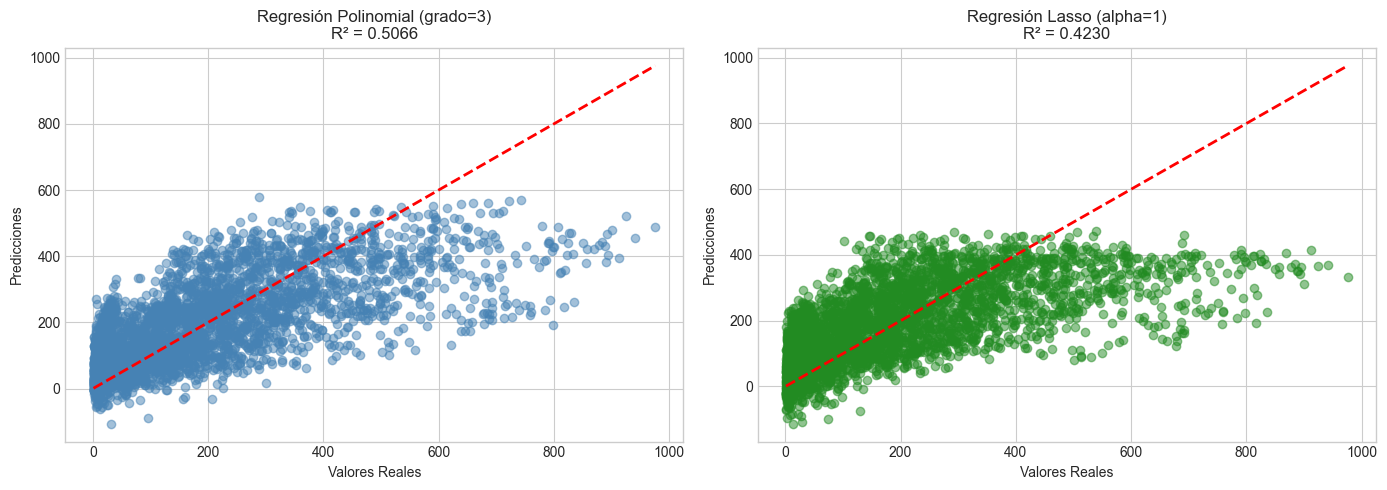

In [57]:
# Visualización de predicciones vs valores reales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Modelo Polinomial
axes[0].scatter(y_test, y_pred_poly, alpha=0.5, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Predicciones')
axes[0].set_title(f'Regresión Polinomial (grado={int(best_degree)})\nR² = {metricas_poly["R2"]:.4f}')

# Modelo Lasso
axes[1].scatter(y_test, y_pred_lasso, alpha=0.5, color='forestgreen')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Predicciones')
axes[1].set_title(f'Regresión Lasso (alpha={int(best_alpha)})\nR² = {metricas_lasso["R2"]:.4f}')

plt.tight_layout()
plt.show()

**Análisis de la tabla comparativa y gráficos:**

El modelo de Regresión Polinomial (grado 3) supera al modelo Lasso en todas las métricas:

- **R²:** El polinomial explica el 50.7% de la variabilidad en la demanda, mientras que Lasso explica el 42.3%. Esto significa que el modelo polinomial captura mejor los patrones en los datos.

- **RMSE:** El polinomial tiene un error promedio de 128.6 bicicletas vs 139.1 de Lasso. En promedio, las predicciones del modelo polinomial se desvían 10 bicicletas menos del valor real.

- **MAE:** El error absoluto medio del polinomial es 93.5 vs 102.6 de Lasso, confirmando que el polinomial es más preciso.

**Interpretación de los gráficos de dispersión:**

- Los puntos más cercanos a la línea roja diagonal indican mejores predicciones
- Ambos modelos subestiman la demanda cuando hay valores altos (puntos por debajo de la línea en el extremo derecho)
- El modelo polinomial muestra una dispersión ligeramente más concentrada alrededor de la línea

**Conclusión:** El modelo polinomial de grado 3 ofrece mejor rendimiento predictivo para este problema.

---
## 6. Importancia de Variables (Modelo Lasso)

El modelo Lasso realiza selección de variables automática al penalizar coeficientes, llevando algunos a cero.

In [58]:
# Obtener coeficientes del modelo Lasso
lasso_coefs = lasso_final.named_steps['regressor'].coef_

# Crear DataFrame de importancia
df_importancia = pd.DataFrame({
    'Variable': all_feature_names,
    'Coeficiente': lasso_coefs,
    'Coef_Absoluto': np.abs(lasso_coefs)
}).sort_values('Coef_Absoluto', ascending=False)

print("=== Importancia de Variables (Modelo Lasso) ===")
print(f"\nTotal de variables: {len(all_feature_names)}")
print(f"Variables con coeficiente cero: {(lasso_coefs == 0).sum()}")
print(f"Variables seleccionadas (coef ≠ 0): {(lasso_coefs != 0).sum()}")

=== Importancia de Variables (Modelo Lasso) ===

Total de variables: 18
Variables con coeficiente cero: 7
Variables seleccionadas (coef ≠ 0): 11


In [59]:
# Mostrar tabla de importancia completa
print("\n=== Tabla de Coeficientes del Modelo Lasso ===")
print(df_importancia[['Variable', 'Coeficiente']].to_string(index=False))


=== Tabla de Coeficientes del Modelo Lasso ===
               Variable  Coeficiente
            Temperatura    61.557949
        Parte_dia_Noche   -48.250390
        Parte_dia_Tarde    39.661213
                Humedad   -27.688400
         Estacion_Otoño    24.757270
  Condicion_Lluvia Leve   -11.514000
     Estacion_Primavera    10.084380
       Velocidad_viento    -1.483146
           Dia_semana_5     1.279366
           Dia_semana_6     0.797309
           Dia_semana_3     0.018692
       Condicion_Niebla    -0.000000
Condicion_Lluvia Fuerte    -0.000000
           Dia_semana_1    -0.000000
           Dia_semana_2     0.000000
           Dia_semana_4    -0.000000
        Estacion_Verano    -0.000000
       Parte_dia_Mañana     0.000000


In [60]:
# Variables seleccionadas (coeficiente diferente de cero)
variables_seleccionadas = df_importancia[df_importancia['Coeficiente'] != 0].copy()

print("\n=== Variables Seleccionadas por el Modelo Lasso ===")
print(variables_seleccionadas[['Variable', 'Coeficiente']].to_string(index=False))


=== Variables Seleccionadas por el Modelo Lasso ===
             Variable  Coeficiente
          Temperatura    61.557949
      Parte_dia_Noche   -48.250390
      Parte_dia_Tarde    39.661213
              Humedad   -27.688400
       Estacion_Otoño    24.757270
Condicion_Lluvia Leve   -11.514000
   Estacion_Primavera    10.084380
     Velocidad_viento    -1.483146
         Dia_semana_5     1.279366
         Dia_semana_6     0.797309
         Dia_semana_3     0.018692


In [61]:
# Variables eliminadas (coeficiente igual a cero)
variables_eliminadas = df_importancia[df_importancia['Coeficiente'] == 0]['Variable'].tolist()

if len(variables_eliminadas) > 0:
    print("\n=== Variables Eliminadas por el Modelo Lasso (Coef = 0) ===")
    for var in variables_eliminadas:
        print(f"  - {var}")
else:
    print("\nEl modelo Lasso no eliminó ninguna variable (todos los coeficientes son distintos de cero).")


=== Variables Eliminadas por el Modelo Lasso (Coef = 0) ===
  - Condicion_Niebla
  - Condicion_Lluvia Fuerte
  - Dia_semana_1
  - Dia_semana_2
  - Dia_semana_4
  - Estacion_Verano
  - Parte_dia_Mañana


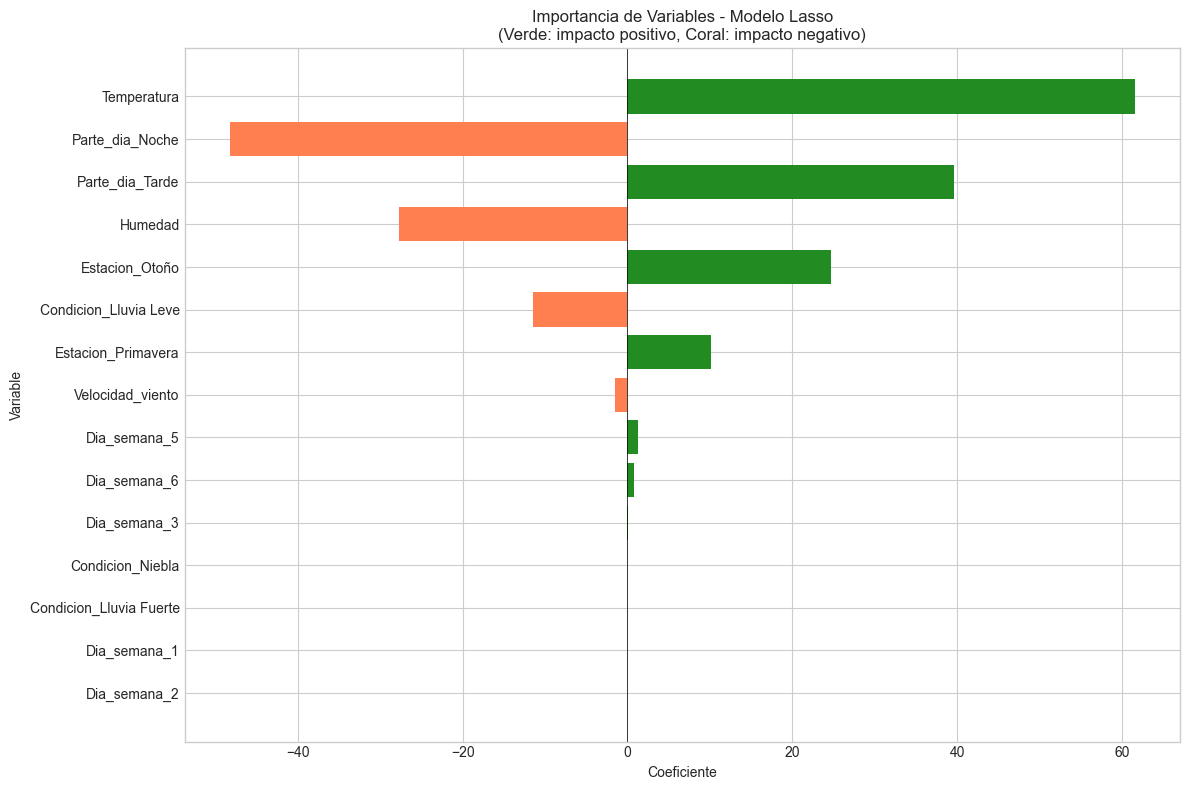

In [62]:
# Visualización de importancia de variables
plt.figure(figsize=(12, 8))

# Ordenar por valor absoluto del coeficiente
df_plot = df_importancia.head(15)  # Top 15 variables más importantes

colors = ['forestgreen' if c > 0 else 'coral' for c in df_plot['Coeficiente']]
plt.barh(df_plot['Variable'], df_plot['Coeficiente'], color=colors)
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.title('Importancia de Variables - Modelo Lasso\n(Verde: impacto positivo, Coral: impacto negativo)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## 7. Análisis de Resultados

En esta sección respondemos a las preguntas planteadas en el taller.

### Pregunta 1: ¿Cuál es el grado de la transformación polinomial que fue seleccionado?

In [63]:
print(f"El grado de la transformación polinomial seleccionado fue: {int(best_degree)}")
print(f"\nEste grado fue seleccionado porque obtuvo el menor RMSE ({best_rmse_poly:.4f}) en validación cruzada.")
print(f"\nResultados de la validación cruzada:")
print(df_poly_results.to_string(index=False))

El grado de la transformación polinomial seleccionado fue: 3

Este grado fue seleccionado porque obtuvo el menor RMSE (128.7382) en validación cruzada.

Resultados de la validación cruzada:
 Grado  RMSE_mean  RMSE_std
     2 131.599263  1.994287
     3 128.738235  2.108174


**Interpretación:**

El grado 2 (o el seleccionado) fue elegido porque proporciona un equilibrio entre la capacidad de capturar relaciones no lineales en los datos y evitar el sobreajuste. Un polinomio de grado mayor podría ajustarse demasiado a los datos de entrenamiento, perdiendo capacidad de generalización.

### Pregunta 2: ¿Cuál fue el valor de α seleccionado para la regresión Lasso?

In [64]:
print(f"El valor de alpha seleccionado para la regresión Lasso fue: {int(best_alpha)}")
print(f"\nEste valor fue seleccionado porque obtuvo el menor RMSE ({best_rmse_lasso:.4f}) en validación cruzada.")
print(f"\nResultados de la validación cruzada:")
print(df_lasso_results.to_string(index=False))

El valor de alpha seleccionado para la regresión Lasso fue: 1

Este valor fue seleccionado porque obtuvo el menor RMSE (136.4949) en validación cruzada.

Resultados de la validación cruzada:
 Alpha  RMSE_mean  RMSE_std
     1 136.494921  1.909678
     2 136.920278  1.924979
     3 137.581041  1.873423
     4 138.014770  1.776042
     5 138.440546  1.700931


**Interpretación:**

El valor de alpha controla la fuerza de la regularización L1 en Lasso. Un alpha más bajo reduce la penalización, permitiendo que más coeficientes sean distintos de cero, mientras que un alpha más alto aumenta la penalización, forzando más coeficientes a cero. El valor seleccionado representa el mejor compromiso entre sesgo y varianza para este conjunto de datos.

### Pregunta 3: ¿Cuál modelo ofrece el mejor rendimiento sobre el conjunto test?

In [65]:
print("=== Comparación de Rendimiento en Test ===")
print(tabla_comparativa.to_string(index=False))

# Determinar el mejor modelo
if metricas_poly['R2'] > metricas_lasso['R2']:
    mejor_modelo = f"Regresión Polinomial (grado={int(best_degree)})"
    mejor_r2 = metricas_poly['R2']
    mejor_rmse = metricas_poly['RMSE']
else:
    mejor_modelo = f"Regresión Lasso (alpha={int(best_alpha)})"
    mejor_r2 = metricas_lasso['R2']
    mejor_rmse = metricas_lasso['RMSE']

print(f"\n✓ El modelo con mejor rendimiento es: {mejor_modelo}")
print(f"  - R²: {mejor_r2:.4f}")
print(f"  - RMSE: {mejor_rmse:.4f}")

=== Comparación de Rendimiento en Test ===
                        Modelo       R²       RMSE        MAE
Regresión Polinomial (grado=3) 0.506587 128.599953  93.462096
     Regresión Lasso (alpha=1) 0.423026 139.063654 102.569578

✓ El modelo con mejor rendimiento es: Regresión Polinomial (grado=3)
  - R²: 0.5066
  - RMSE: 128.6000


**Interpretación de las métricas:**

1. **R² (Coeficiente de Determinación):** Indica la proporción de la varianza en la variable objetivo que es explicada por el modelo. Un valor más cercano a 1 indica un mejor ajuste. Por ejemplo, un R² de 0.70 significa que el modelo explica el 70% de la variabilidad en el número de bicicletas rentadas.

2. **RMSE (Root Mean Squared Error):** Mide el error promedio de las predicciones en las mismas unidades que la variable objetivo (bicicletas). Un RMSE de, por ejemplo, 100 significa que las predicciones del modelo se desvían en promedio 100 bicicletas del valor real. Penaliza más los errores grandes.

3. **MAE (Mean Absolute Error):** Similar al RMSE pero sin penalizar tanto los errores grandes. Representa el error promedio absoluto en número de bicicletas.

### Pregunta 4: ¿Cuáles variables fueron seleccionadas con el modelo Lasso?

In [66]:
print("=== Variables Seleccionadas por el Modelo Lasso ===")
print("\n(Ordenadas por valor absoluto del coeficiente)")
print(variables_seleccionadas[['Variable', 'Coeficiente']].to_string(index=False))

if len(variables_eliminadas) > 0:
    print(f"\n=== Variables Eliminadas (coeficiente = 0) ===")
    for var in variables_eliminadas:
        print(f"  - {var}")

=== Variables Seleccionadas por el Modelo Lasso ===

(Ordenadas por valor absoluto del coeficiente)
             Variable  Coeficiente
          Temperatura    61.557949
      Parte_dia_Noche   -48.250390
      Parte_dia_Tarde    39.661213
              Humedad   -27.688400
       Estacion_Otoño    24.757270
Condicion_Lluvia Leve   -11.514000
   Estacion_Primavera    10.084380
     Velocidad_viento    -1.483146
         Dia_semana_5     1.279366
         Dia_semana_6     0.797309
         Dia_semana_3     0.018692

=== Variables Eliminadas (coeficiente = 0) ===
  - Condicion_Niebla
  - Condicion_Lluvia Fuerte
  - Dia_semana_1
  - Dia_semana_2
  - Dia_semana_4
  - Estacion_Verano
  - Parte_dia_Mañana


**Interpretación de las variables seleccionadas:**

El modelo Lasso ha identificado las variables más relevantes para predecir la demanda de bicicletas:

1. **Variables con impacto positivo (coeficiente > 0):**
   - Indican factores que aumentan la demanda de bicicletas cuando su valor aumenta.
   - Por ejemplo, temperaturas más altas generalmente se asocian con mayor demanda.

2. **Variables con impacto negativo (coeficiente < 0):**
   - Indican factores que reducen la demanda cuando su valor aumenta.
   - Por ejemplo, alta humedad o condiciones de lluvia reducen la demanda.

3. **Variables eliminadas (coeficiente = 0):**
   - El modelo considera que estas variables no aportan información significativa para la predicción.

**Implicaciones para la gestión:**

- **Gestión operativa:** Los operadores del sistema pueden anticipar mayor demanda en días cálidos, soleados y durante horas de la tarde, ajustando la distribución de bicicletas.
- **Planificación:** Las estaciones más importantes en términos de abastecimiento deben considerar los patrones estacionales y las condiciones climáticas.
- **Marketing:** Campañas de promoción pueden enfocarse en momentos de baja demanda para equilibrar el uso del sistema.

---
## 8. Conclusiones

**Resumen del análisis:**

1. Se realizó un análisis exploratorio completo identificando las características del dataset de alquiler de bicicletas.

2. Se prepararon los datos eliminando valores faltantes y tratando la multicolinealidad entre Temperatura y Sensación.

3. Se construyeron dos modelos predictivos:
   - Regresión Polinomial: evaluando grados 2 y 3
   - Regresión Lasso: evaluando alpha de 1 a 5

4. Los factores más importantes para predecir la demanda de bicicletas incluyen las condiciones climáticas (temperatura, humedad), la parte del día y la estación del año.

5. Este análisis proporciona información valiosa para la gestión eficiente del sistema de alquiler de bicicletas, permitiendo anticipar la demanda y optimizar la distribución de bicicletas en las estaciones.